In [3]:
from scipy.stats import bernoulli
from scipy.stats import beta
from scipy.stats import gamma
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Win-rate simulation

## Constant probability distribution

In [4]:
def run(delta, hour_window, shift, support_percent, verbose=False):
    
    # Shared params
    num_days = 2
    num_hours = num_days * 24
    num_total_auctions = 10000
    support = int(support_percent * num_total_auctions)
    
    num_trials = 5000
    num_actions = 3
    
    num_auctions0 = num_total_auctions * np.ones(3) * (1 / num_actions)
    num_auctions = num_auctions0
    
    # For regret calculation
    regrets = np.zeros(num_hours)
    
    # Win-rate (Bernoulli rv -- Beta distribution)
    p_arr = [0.11 - delta, 0.11, 0.11 + delta]
    alpha0 = 1
    beta0  = 1

    alpha_arr = np.zeros((num_hours, num_actions))
    beta_arr = np.zeros((num_hours, num_actions))    
            
    prob_array = np.zeros((num_hours, num_actions))
    for hour in range(num_hours):

        win_rates = np.zeros((num_actions, num_trials))    
        taus = np.zeros((num_actions, num_trials))
        mean_logpubrevs = np.zeros((num_actions, num_trials))
        mean_pubrevs = np.zeros((num_actions, num_trials))
        
        for i in range(num_actions):
            # Win-rate simulation
            simulated_wins = bernoulli.rvs(p_arr[i], size=int(num_auctions[i]))

            alpha_arr[hour, i] = simulated_wins.sum()
            beta_arr[hour, i] = num_auctions[i] - alpha_arr[hour, i]
            
            prev_alpha = 0
            prev_beta = 0
            for prev in range(hour-shift, hour-shift-hour_window, -1):
                if prev < 0: 
                    break
                prev_alpha += alpha_arr[prev, i]
                prev_beta += beta_arr[prev, i]
                
            _alpha = max(prev_alpha + alpha0, 1)
            _beta = max(prev_beta + beta0, 1)

            win_rates[i] = beta.rvs(_alpha, _beta, size=num_trials)
            
        winners = np.argmax(win_rates, axis=0)

        prob_to_wins = []
        for i in range(num_actions):
            prob_to_win = (np.where(winners == i, 1, 0).sum() + support) \
                            / (num_trials + support * num_actions)
            num_auctions[i] = int(num_total_auctions * prob_to_win)
            prob_to_wins.append(prob_to_win)

        prob_array[hour] = np.array(prob_to_wins)

        # Regret calculation
        optimal_winrate = p_arr[-1]
        optimal_result = optimal_winrate
        regrets[hour] = optimal_result - alpha_arr[hour, :].sum() / num_total_auctions
                
    
    cumulative_regrets = regrets.cumsum()
    avg_regrets = cumulative_regrets / np.arange(1, (num_hours+1), 1)

    
    if verbose:
        fig, ax = plt.subplots(figsize=(16,4))
        ax.stackplot(
            range(24 * num_days), 
            prob_array[:,0], 
            prob_array[:,1], 
            prob_array[:,2], 
            labels=[f"p={x:.4f}" for x in p_arr]
        )
        ax.legend()
        ax.set_title(f"Probabilities: delta={delta:.0e}")
        
        plt.savefig(f"../output/probabilities_d={delta:.0e}.png", dpi=150)
        for i in range(num_actions):
            print(f"p[{p_arr[i]}] = {prob_array[:,i].sum() / len(prob_array):.3f}")
    
        
    return avg_regrets

p[0.1099] = 0.344
p[0.11] = 0.312
p[0.1101] = 0.344


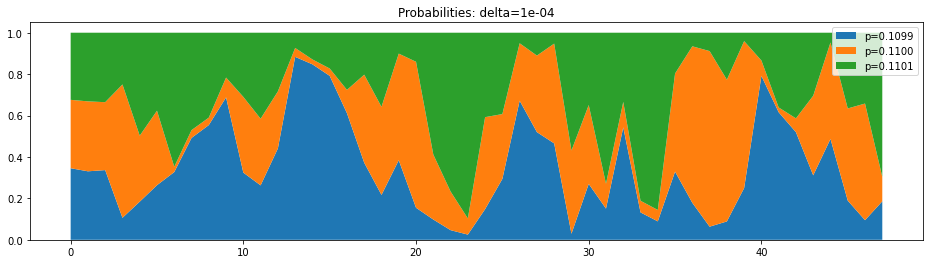

In [5]:
_ = run(delta=1e-4, hour_window=3, shift=3, supportverbose=True)

p[0.1] = 0.065
p[0.11] = 0.195
p[0.12] = 0.740


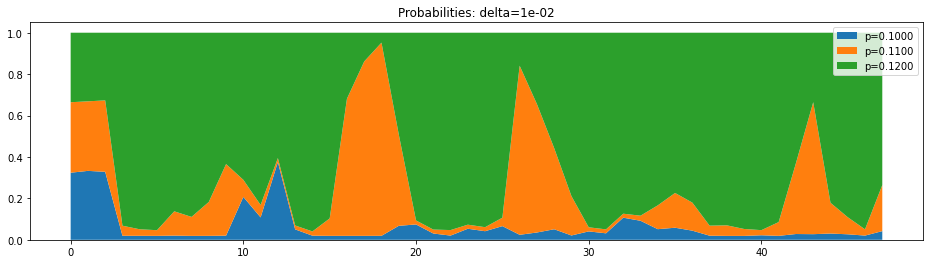

In [9]:
_ = run(delta=1e-2, hour_window=3, shift=3, verbose=True)

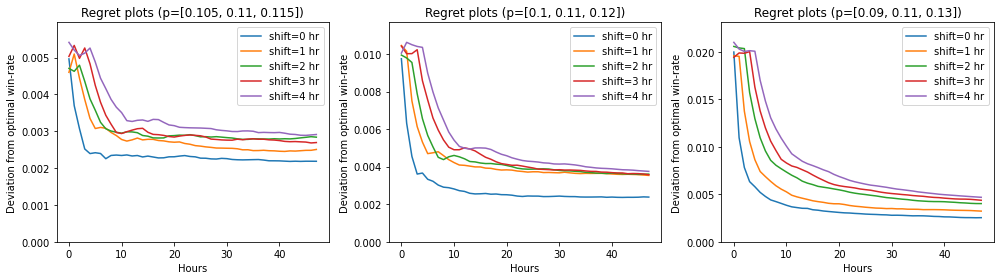

In [28]:
NUM_TRIES = 50

fig, axes = plt.subplots(1, 3, figsize=(14,4))

for idx, delta in enumerate([5e-3, 1e-2, 2e-2]):
    
    ax = axes[idx]
    for shift in range(5):
        total_avg_regrets = np.zeros(24 * 2)
        for _ in range(NUM_TRIES):
            avg_regrets = run(delta=delta, hour_window=3, shift=shift, verbose=False)
            total_avg_regrets += avg_regrets

        avg_avg_regrets = total_avg_regrets / NUM_TRIES
        
        ax.plot(avg_avg_regrets, label=f"shift={shift} hr")
        
    probs = [np.round(0.11 + x, 3) for x in [-delta, 0, delta]]

    ax.legend()
    ax.set_title(f"Regret plots (p={probs})")
    ax.set_xlabel("Hours")
    ax.set_ylabel("Deviation from optimal win-rate")
    ax.set_ylim(0, avg_avg_regrets.max() * 1.1)

fig.tight_layout()
fig.savefig("../output/winrate_regret.png", dpi=150, transparent=False)

## Time-varying probability distribution

In [ ]:
def run_dt(delta, hour_window, verbose=False):
    
    # Shared params
    num_days = 2
    num_hours = num_days * 24
    num_total_auctions = 10000
    support = int(0.01 * num_total_auctions)
    
    num_trials = 5000
    num_actions = 3
    
    num_auctions0 = num_total_auctions * np.ones(3) * (1 / num_actions)
    num_auctions = num_auctions0
    
    # For regret calculation
    regrets = np.zeros(num_hours)
    
    # Win-rate (Bernoulli rv -- Beta distribution)
    p_arr = np.zeros((num_hours, num_actions))
    t = np.arange(0, num_hours, 1)
    p_arr[:, 0] = 0.04 * np.sin(2 * np.pi * (t - 3)/ 24) + 0.11
    p_arr[:, 1] = 0.02 * np.sin(2 * np.pi * t / (24-3) ) + 0.12
    p_arr[:, 2] = 0.02 * np.sin(2 * np.pi * (t + 4) / (24+8)) + 0.13
    

    alpha0 = 1
    beta0  = 1

    alpha_arr = np.zeros((num_hours, num_actions))
    beta_arr = np.zeros((num_hours, num_actions))    
            
    prob_array = np.zeros((num_hours, num_actions))
    for hour in range(num_hours):

        win_rates = np.zeros((num_actions, num_trials))    
        taus = np.zeros((num_actions, num_trials))
        mean_logpubrevs = np.zeros((num_actions, num_trials))
        mean_pubrevs = np.zeros((num_actions, num_trials))
        
        for i in range(num_actions):
            # Win-rate simulation
            simulated_wins = bernoulli.rvs(p_arr[hour, i], size=int(num_auctions[i]))

            alpha_arr[hour, i] = simulated_wins.sum()
            beta_arr[hour, i] = num_auctions[i] - alpha_arr[hour, i]
            
            prev_alpha = 0
            prev_beta = 0
            for prev in range(hour-1, hour-1-hour_window, -1):
                if prev < 0: 
                    break
                prev_alpha += alpha_arr[prev, i]
                prev_beta += beta_arr[prev, i]
                
            _alpha = max(alpha_arr[hour,i] + prev_alpha + alpha0, 1)
            _beta = max(beta_arr[hour,i] + prev_beta + beta0, 1)

            win_rates[i] = beta.rvs(_alpha, _beta, size=num_trials)
            
        winners = np.argmax(win_rates, axis=0)

        prob_to_wins = []
        for i in range(num_actions):
            prob_to_win = (np.where(winners == i, 1, 0).sum() + support) \
                            / (num_trials + support * num_actions)
            num_auctions[i] = int(num_total_auctions * prob_to_win)
            prob_to_wins.append(prob_to_win)

        prob_array[hour] = np.array(prob_to_wins)

    # Regret calculation
    optimal_winrate = p_arr[:, -1]
    optimal_result = optimal_winrate
    regrets = optimal_result - np.sum(alpha_arr, axis=1) / num_total_auctions
                
    
    cumulative_regrets = regrets.cumsum()
    avg_regrets = cumulative_regrets / np.arange(1, (num_hours+1), 1)

    
    if verbose:
        fig, axes = plt.subplots(2, 1, figsize=(12,8))
        axes[1].stackplot(
            range(24 * num_days), 
            prob_array[:,0], 
            prob_array[:,1], 
            prob_array[:,2], 
            labels=[f"p_{i}" for i in range(3)]
        )
        axes[1].legend()
        axes[1].set_title(f"Probability of choosing each action")
        
        for i in range(3):
            axes[0].plot(p_arr[:,i], label=f"p_{i}")
        axes[0].legend()
        axes[0].set_title(f"Underlying probabilities")

        plt.tight_layout()
        plt.savefig(f"../output/time_varying_probabilities.png", dpi=150)
        for i in range(num_actions):
            print(f"p[{p_arr[0, i]}] = {prob_array[:,i].sum() / len(prob_array):.3f}")
    
        
    return avg_regrets

In [ ]:
_ = run_dt(0.1, 3, verbose=True)

# Win-rate + pubrev

## Case 0: there's a clear winner

In [ ]:
def run_wp(delta_win, delta_logpubrev, hour_window, verbose=False):
    
    # Shared params
    num_days = 2
    num_hours = num_days * 24
    num_total_auctions = 10000
    support = int(0.01 * num_total_auctions)
    
    num_trials = 5000
    num_actions = 3
    
    num_auctions0 = num_total_auctions * np.ones(3) * (1 / num_actions)
    num_auctions = num_auctions0
    
    # For regret calculation
    regrets = np.zeros(num_hours)
    
    # Win-rate (Bernoulli rv -- Beta distribution)
    p_arr = [0.11 - delta_win, 0.11, 0.11 + delta_win]
    alpha0 = 1
    beta0  = 1

    alpha_arr = np.zeros((num_hours, num_actions))
    beta_arr = np.zeros((num_hours, num_actions))    
    
    # Pubrev (log-normal distribution -- gamma + normal distribution)
    mu_arr = [13.3, 13.3, 13.3]
    std = 0.1
    
    mu0 = 13.3
    v0 = 2
    a0 = v0 // 2
    b0 = 1
    
    v_arr = np.zeros((num_hours, num_actions))
    deviation_arr = np.zeros((num_hours, num_actions))
    logpubrev_sum_arr = np.zeros((num_hours, num_actions))
    
    prev_wins = np.zeros(num_actions)
    prev_sums = np.zeros(num_actions)
    curr_means = np.zeros(num_actions)
    prev_deviations = np.zeros(num_actions)
        
    prob_array = np.zeros((num_hours, num_actions))
    for hour in range(num_hours):

        win_rates = np.zeros((num_actions, num_trials))    
        taus = np.zeros((num_actions, num_trials))
        mean_logpubrevs = np.zeros((num_actions, num_trials))
        mean_pubrevs = np.zeros((num_actions, num_trials))
        
        for i in range(num_actions):
            # Win-rate simulation
            simulated_wins = bernoulli.rvs(p_arr[i], size=int(num_auctions[i]))

            alpha_arr[hour, i] = simulated_wins.sum()
            beta_arr[hour, i] = num_auctions[i] - alpha_arr[hour, i]
            
            prev_alpha = 0
            prev_beta = 0
            for prev in range(hour-1, hour-1-hour_window, -1):
                if prev < 0: 
                    break
                prev_alpha += alpha_arr[prev, i]
                prev_beta += beta_arr[prev, i]
                
            _alpha = max(alpha_arr[hour,i] + prev_alpha + alpha0, 1)
            _beta = max(beta_arr[hour,i] + prev_beta + beta0, 1)

            win_rates[i] = beta.rvs(_alpha, _beta, size=num_trials)
            
            # Pub-rev simulation
            simulated_logpubrevs = norm.rvs(loc=mu_arr[i], scale=std, size=int(alpha_arr[hour, i]))
            
            logpubrev_sum_arr[hour, i] = simulated_logpubrevs.sum()
            deviation_arr[hour, i] = 0.5 * alpha_arr[hour, i] * (simulated_logpubrevs.std() ** 2)
            
            prev_wins[i] = 0
            prev_sums[i] = 0
            prev_deviations[i] = 0
            for prev in range(hour-1, hour-1-hour_window, -1):
                if prev < 0:
                    break
                prev_wins[i] += alpha_arr[prev, i]
                prev_sums[i] += logpubrev_sum_arr[prev, i]
                prev_deviations[i] += deviation_arr[prev, i]
                
            _v = _alpha
            _a = max(_alpha // 2, 1)
            
            curr_wins = alpha_arr[hour, i] + prev_wins[i]
            curr_means[i] = (logpubrev_sum_arr[hour, i] + prev_sums[i]) / curr_wins
            curr_deviation = deviation_arr[hour, i] + prev_deviations[i]
            
            _mu = (mu0 * v0 + _v * curr_means[i]) / (v0 + _v)
            _b = b0 + curr_deviation + (_v * v0) / (_v + v0) * (curr_means[i] - mu0) ** 2 / 2
            
            taus[i] = gamma.rvs(_a, scale=1/_b, size=num_trials)
            mean_logpubrevs[i] = norm.rvs(loc=_mu, scale=np.sqrt(1 / (_v + taus[i])))
            
            mean_pubrevs[i] = np.exp(mean_logpubrevs[i] + 1 / (2 * _v * taus[i]))
            
        winners = np.argmax(win_rates * mean_pubrevs, axis=0)

        prob_to_wins = []
        for i in range(num_actions):
            prob_to_win = (np.where(winners == i, 1, 0).sum() + support) \
                            / (num_trials + support * num_actions)
            num_auctions[i] = int(num_total_auctions * prob_to_win)
            prob_to_wins.append(prob_to_win)

        prob_array[hour] = np.array(prob_to_wins)

        # Regret calculation
        optimal_winrate = p_arr[-1]
        optimal_pubrev = np.exp(mu_arr[-1] + std ** 2 / 2)
        optimal_result = optimal_winrate * optimal_pubrev
        
        variances = 2 * (deviation_arr[hour, :] + prev_deviations) / alpha_arr[hour, :]
        regrets[hour] = optimal_result - ((alpha_arr[hour, :] / num_total_auctions) * np.exp(curr_means)).sum()                
    
    cumulative_regrets = regrets.cumsum()
    num_total_auctions_arr = np.arange(num_total_auctions, (num_hours+1) * num_total_auctions, num_total_auctions)
    avg_regrets = cumulative_regrets / num_total_auctions_arr
    avg_regrets = cumulative_regrets / np.arange(1, (num_hours+1), 1)

    
    if verbose:
        fig, ax = plt.subplots(figsize=(16,4))
        ax.stackplot(range(24 * num_days), prob_array[:,0], prob_array[:,1], prob_array[:,2], labels=[str(x) for x in p_arr])
        ax.legend()

        for i in range(num_actions):
            print(f"p[{p_arr[i]}] = {prob_array[:,i].sum() / len(prob_array):.3f}")
    
    return avg_regrets

In [ ]:
_ = run_wp(delta_win=2e-2, delta_logpubrev=0, hour_window=3, verbose=True)

In [ ]:
NUM_TRIES = 20

fig, ax = plt.subplots(figsize=(6,6))

for delta in [5e-3, 1e-2, 2e-2]:
    total_avg_regrets = np.zeros(24 * 2)
    for _ in range(NUM_TRIES):
        avg_regrets = run_wp(delta_win=delta, delta_logpubrev=0, hour_window=3, verbose=False)
        total_avg_regrets += avg_regrets

    avg_avg_regrets = total_avg_regrets / NUM_TRIES
    
    probs = [np.round(0.11 + x, 3) for x in [-delta, 0, delta]]
    ax.plot(avg_avg_regrets, label=f"p={probs}")

ax.legend()
ax.set_title("Regrets for different deltas")
ax.set_xlabel("Hours")
ax.set_ylabel("Deviation from optimal win-rate * pubrev")
ax.set_ylim(0, 1.5e4)

plt.savefig("../output/winrate_pubrev_regret.png", dpi=150, transparent=False)

## Win-rate * pubrev's are same but win-rates are different

In [ ]:
# Win-rate (Bernoulli rv -- Beta distribution)
delta = 0.01
p0 = 0.11
p_arr = [p0 - delta, p0, p0 + delta]
print(p_arr)

# Pubrev (log-normal distribution -- gamma + normal distribution)
mu0 = 13.3
std = 0.1
mu_arr = [mu0 + np.log(p0 / (p0 - delta)), mu0, mu0 + np.log(p0 / (p0 + delta))]
print(mu_arr)

for i in range(3):
    simulated_wins = bernoulli.rvs(p_arr[i], size=100000)
    simulated_logpubrevs = norm.rvs(loc=mu_arr[i], scale=std, size=100000)

    simulated_pubrevs = np.exp(simulated_logpubrevs)
    
    expected_pubrev = simulated_wins.mean() * simulated_pubrevs.mean()
    print(f"{simulated_wins.mean() / p_arr[i]:.3f}")
    print(f"{simulated_pubrevs.mean() / np.exp(mu_arr[i] + std ** 2 / 2):.3f}")
    
    print(f"Expected revenue_{i}: {expected_pubrev:.1f}")
    

In [ ]:
def run_equiv(delta, hour_window, num_days, verbose=False):
    
    # Shared params
    num_hours = num_days * 24
    num_total_auctions = 10000
    support = int(0.01 * num_total_auctions)
    
    num_trials = 5000
    num_actions = 3
    
    num_auctions0 = num_total_auctions * np.ones(3) * (1 / num_actions)
    num_auctions = num_auctions0
    
    # For regret calculation
    regrets = np.zeros(num_hours)
    
    # Win-rate (Bernoulli rv -- Beta distribution)
    p0 = 0.11
    p_arr = [p0 - delta, p0, p0 + delta]
    alpha0 = 1
    beta0  = 9

    alpha_arr = np.zeros((num_hours, num_actions))
    beta_arr = np.zeros((num_hours, num_actions))    
    
    # Pubrev (log-normal distribution -- gamma + normal distribution)
    mu0 = 13.3
    mu_arr = [mu0 + np.log(p0 / (p0 - delta)), mu0, mu0 + np.log(p0 / (p0 + delta))]
    std = 0.1
    
    mu0 = 13.3
    v0 = 2
    a0 = v0 // 2
    b0 = 1
    
    v_arr = np.zeros((num_hours, num_actions))
    deviation_arr = np.zeros((num_hours, num_actions))
    logpubrev_sum_arr = np.zeros((num_hours, num_actions))
    
    prev_wins = np.zeros(num_actions)
    prev_sums = np.zeros(num_actions)
    curr_means = np.zeros(num_actions)
    prev_deviations = np.zeros(num_actions)
        
    prob_array = np.zeros((num_hours, num_actions))
    for hour in range(num_hours):

        win_rates = np.zeros((num_actions, num_trials))    
        taus = np.zeros((num_actions, num_trials))
        mean_logpubrevs = np.zeros((num_actions, num_trials))
        mean_pubrevs = np.zeros((num_actions, num_trials))
        
        for i in range(num_actions):
            # Win-rate simulation
            simulated_wins = bernoulli.rvs(p_arr[i], size=int(num_auctions[i]))

            alpha_arr[hour, i] = simulated_wins.sum()
            beta_arr[hour, i] = num_auctions[i] - alpha_arr[hour, i]
            
            prev_alpha = 0
            prev_beta = 0
            for prev in range(hour-1, hour-1-hour_window, -1):
                if prev < 0: 
                    break
                prev_alpha += alpha_arr[prev, i]
                prev_beta += beta_arr[prev, i]
                
            _alpha = max(alpha_arr[hour,i] + prev_alpha + alpha0, 1)
            _beta = max(beta_arr[hour,i] + prev_beta + beta0, 1)

            win_rates[i] = beta.rvs(_alpha, _beta, size=num_trials)
            
            # Pub-rev simulation
            simulated_logpubrevs = norm.rvs(loc=mu_arr[i], scale=std, size=int(alpha_arr[hour, i]))
            
            logpubrev_sum_arr[hour, i] = simulated_logpubrevs.sum()
            deviation_arr[hour, i] = 0.5 * alpha_arr[hour, i] * (simulated_logpubrevs.std() ** 2)
            
            prev_wins[i] = 0
            prev_sums[i] = 0
            prev_deviations[i] = 0
            for prev in range(hour-1, hour-1-hour_window, -1):
                if prev < 0:
                    break
                prev_wins[i] += alpha_arr[prev, i]
                prev_sums[i] += logpubrev_sum_arr[prev, i]
                prev_deviations[i] += deviation_arr[prev, i]
                
            _v = _alpha
            _a = max(_alpha // 2, 1)
            
            curr_wins = alpha_arr[hour, i] + prev_wins[i]
            curr_means[i] = (logpubrev_sum_arr[hour, i] + prev_sums[i]) / curr_wins
            curr_deviation = deviation_arr[hour, i] + prev_deviations[i]
            
            _mu = (mu0 * v0 + _v * curr_means[i]) / (v0 + _v)
            _b = b0 + curr_deviation + (_v * v0) / (_v + v0) * (curr_means[i] - mu0) ** 2 / 2
            
            taus[i] = gamma.rvs(_a, scale=1/_b, size=num_trials)
            mean_logpubrevs[i] = norm.rvs(loc=_mu, scale=np.sqrt(1 / (_v + taus[i])))
            
            mean_pubrevs[i] = np.exp(mean_logpubrevs[i] + 1 / (2 * _v * taus[i]))
            
            
        winners = np.argmax(win_rates * mean_pubrevs, axis=0)

        prob_to_wins = []
        for i in range(num_actions):
            prob_to_win = (np.where(winners == i, 1, 0).sum() + support) \
                            / (num_trials + support * num_actions)
            num_auctions[i] = int(num_total_auctions * prob_to_win)
            prob_to_wins.append(prob_to_win)

        prob_array[hour] = np.array(prob_to_wins)

        # Regret calculation
        optimal_winrate = p_arr[1]
        optimal_pubrev = np.exp(mu_arr[1] + std ** 2 / 2)
        optimal_result = optimal_winrate * optimal_pubrev
        
        variances = 2 * (deviation_arr[hour, :] + prev_deviations) / alpha_arr[hour, :]
        regrets[hour] = optimal_result - ((alpha_arr[hour, :] / num_total_auctions) * np.exp(curr_means)).sum() 
                
    
    cumulative_regrets = regrets.cumsum()
    num_total_auctions_arr = np.arange(num_total_auctions, (num_hours+1) * num_total_auctions, num_total_auctions)
    avg_regrets = cumulative_regrets / num_total_auctions_arr
    avg_regrets = cumulative_regrets / np.arange(1, (num_hours+1), 1)

    
    if verbose:
        fig, ax = plt.subplots(figsize=(16,4))
        ax.stackplot(range(24 * num_days), prob_array[:,0], prob_array[:,1], prob_array[:,2], labels=[f"p={p:.2f}" for p in p_arr])
        ax.legend()
        ax.set_title(f"Probability of choosing each action")
        
        plt.savefig(f"../output/equivalent_actions.png", dpi=150)
        
        for i in range(num_actions):
            print(f"p[{p_arr[i]}] = {prob_array[:,i].sum() / len(prob_array):.3f}")
    
    return avg_regrets

In [ ]:
_ = run_equiv(delta=0.05, hour_window=3, num_days=3, verbose=True)

In [ ]:
NUM_TRIES = 50
NUM_DAYS = 2

fig, ax = plt.subplots(figsize=(6,6))

for delta in [5e-3, 1e-2, 2e-2]:
    total_avg_regrets = np.zeros(24 * NUM_DAYS)
    for _ in range(NUM_TRIES):
        avg_regrets = run_equiv(delta=delta, hour_window=3, num_days=NUM_DAYS, verbose=False)
        total_avg_regrets += avg_regrets

    avg_avg_regrets = total_avg_regrets / NUM_TRIES
    
    probs = [np.round(0.11 + x, 3) for x in [-delta, 0, delta]]
    ax.plot(avg_avg_regrets, label=f"p={probs}")

ax.legend()
ax.set_title("Regrets for different deltas")
ax.set_xlabel("Hours")
ax.set_ylabel("Deviation from optimal win-rate * pubrev")
ax.set_ylim(0, 1e3)

plt.savefig("../output/equiv_winrate_pubrev_regret.png", dpi=150, transparent=False)